## **Downloading the data and required libraries**

---



Below we started by installing spaCy.

spaCy is a great library that can be used for Natural Language Processing, as you will see later below.

In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In the cell below, we decided to import all the necessary libraries all at once for cleanliness and better readability of further written code.


In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

#**Re-Arrangement of Gathered Datasets**

In the cell below, we are reading our necessary input and output sample data from the RateMyProfessor_Sample.csv and all_reviews.json file and creating a single dataframe.

In [ ]:
import pandas as pd
df = pd.read_csv("/content/RateMyProfessor_Sample data.csv",usecols=["student_star","student_difficult","comments"])

import pandas as pd
import json

# read the JSON file into a list of dictionaries
with open('all_reviews.json', 'r') as f:
    data_json = json.load(f)

# select only the columns you need from the JSON data
data_selected = []
count = 0

for inner_list in data_json:
    for row in inner_list:
        count += 1
        data_selected.append({
            'student_star': row['Quality'],
            'student_difficult': row['Difficulty'],
            'comments': row['Comment']
        })

# create a DataFrame with the selected columns
df_json = pd.DataFrame(data_selected)

# concatenate the two DataFrames to create a new DataFrame with the additional rows from the JSON file
df_combined = pd.concat([df, df_json], ignore_index=True)

df = df_combined

In [ ]:
# Convert the dataframe to a CSV file
df.to_csv('output.csv',index=False)

# Read the csv file and just fetch the required columns
df = pd.read_csv("output.csv",usecols=["student_star","student_difficult","comments"])

# Eliminate rows that are null
if df.isnull().values.any():
    df = df.dropna()

print(df.shape)


(23360, 3)


In [ ]:
# shuffle the rows of the DataFrame using the sample() method
df_shuffled = df.sample(frac=1, random_state=42)

# reset the index of the shuffled DataFrame
df_shuffled = df_shuffled.reset_index(drop=True)

df = df_shuffled

print(df.shape)

(23360, 3)


## **Data Augmentation:**

---


1.   We are Performing data augmentation on the available datasets which help to improve the model's ability to generalize to new, unseen data by exposing it to a wider variety of examples.
2.   Additionally, it can address class imbalance issues and overcome the issue of limited data by creating new, but similar examples from existing data, thereby increasing the size of the dataset.
3.   Overall, performing data augmentation on the available datasets can help to improve the performance and generalization ability of the RNN model for predicting the quality and difficulty scores of student comments.








The next 5 cells are used to prepare and import the necessary libraries for Data Augmentation.

In [ ]:
#cloning the NL Augmentor Library
!git clone https://www.github.com/GEM-benchmark/NL-Augmenter

Cloning into 'NL-Augmenter'...
remote: Enumerating objects: 12857, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 12857 (delta 2), reused 5 (delta 2), pack-reused 12842
Receiving objects: 100% (12857/12857), 91.62 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (8366/8366), done.
Updating files: 100% (784/784), done.


In [ ]:
# Moving the data in the google colab local folder
%cd /content/NL-Augmenter

/content/NL-Augmenter


In [ ]:
# Downloading the requirements for NL Augmentor
!pip install -r /content/NL-Augmenter/requirements.txt --quiet
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.7/508.7 k

In [ ]:
# Loading the Modules
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nlaugmenter.transformations.butter_fingers_perturbation.transformation import ButterFingersPerturbation


#***what is ButterFingersPertuburation?***

**ButterFingersPerturbation** is a type of perturbation that is specifically designed to introduce spelling mistakes into the text data. It randomly replaces characters in the text with other characters that are near them on a keyboard (e.g., "l" with "k", "o" with "p", etc.) to simulate spelling errors.

The cell below performs Data Augmentation using the ButterFingersPerturbation from the imported NLAugmentor library.

In [ ]:
# Performing Data Augmentation on our Dataset
augmentor = ButterFingersPerturbation(max_outputs=3)
augmented_df = pd.DataFrame(columns = ["comments", "student_star", "student_difficult"])
for i, r in df.iterrows():
  augmented_data = {}
  augmented_sentence = augmentor.generate(r["comments"])
  augmented_data["comments"] = augmented_sentence[0]
  augmented_data["student_star"] = r["student_star"]
  augmented_data["student_difficult"] = r["student_difficult"]
  augmented_data_df = pd.DataFrame([augmented_data])
  augmented_df = pd.concat([augmented_df, augmented_data_df], ignore_index = True)

In [ ]:
# Appending / Concatinating the Augmented Data into our Original Dataset
df = pd.concat([df, augmented_df], ignore_index = True)

## **Performing Data Cleaning and Preprocessing**

---



The cell below uses the spaCy library we started the project with importing.

We end up using it to preprocess all of our text data that we're going to use as input data (the comments data).

Specifically, it is used to remove punctuations and numbers, single characters, multiple spaces, stopwords, lemmatize the text, and make all characters lower case.

In [ ]:
import string

nlp = spacy.load('en_core_web_sm')

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    doc = nlp(sen)

    # Remove punctuations and numbers
    sentence = ' '.join(token.text for token in doc if token.is_alpha)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove Stopwords
    sentence = ' '.join(token.text for token in doc if not token.is_stop)

    # new part
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Lemmatize text
    sentence = ' '.join(token.lemma_ for token in nlp(sentence))

    sentence = sentence.lower()

    return sentence.lower()

X = []
sentences = list(df['comments'])
for sen in sentences:
  X.append(preprocess_text(sen))

star_rate = []
difficulty = []
for index,row in df.iterrows():
    if type(row["comments"]) == str:
        star_rate.append(row["student_star"])
        difficulty.append(row["student_difficult"])


/usr/local/lib/python3.10/dist-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  path (Union[Path, str]): The directory path.


## **Splitting the dataset to training and testing dataset**

---



In [ ]:
# storing both star rating (Quality) and difficulty as the output label
y = np.stack((star_rate,difficulty),axis=1)

# Splitting the dataset among training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train[0])
print(len(X_train))

big trick   do nt ecer tane class
37376


In [ ]:
# Performing the word tokenization

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[0])

[301, 923, 11, 2, 2432, 827, 1]


In [ ]:
import io
import json

tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
vocab_length = len(word_tokenizer.word_index) + 1

print(vocab_length)

# setting the number of words to 100
maxlen = 100

59703


In [ ]:
# performing padding
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## **Importing GLOVE Embedding**

---
#***Why GLOVE?***

1.   Firstly, GLOVE embeddings have been trained on large-scale text data, which can capture a wide range of semantic relationships between words.
2.   Secondly, using GLOVE  can save time and computational resources that would be required to train an embedding model from scratch.

1.   Lastly, GLOVE can be easily integrated into RNN models as input layers to represent the text data as dense vectors.








In the cells below we utilized GloVe for pre-trained word embeddings.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-29 06:13:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-29 06:13:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-29 06:13:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip -q glove.6B.zip

In [ ]:
from numpy import asarray
from numpy import zeros
import os

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split(' ')
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## **Model Architecture:**

---
#### **We are using one model here to predict both quality and difficulty in this section.**
This model architecture is designed to take in text data, process it through a sequence of recurrent layers with L2 regularization and dropout, and output predicted scores for quality and difficulty.


In [ ]:
from keras.models import Sequential
from keras import regularizers
from keras.models import Model
from keras.layers import Input,Embedding,GRU
from keras.layers import RepeatVector, TimeDistributed
from keras.models import Model
from tensorflow.keras import regularizers

# model = Sequential([
#       Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
#         GRU(128),
#         Dense(2, activation='linear')
#     ])

model = Sequential([
      Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
      GRU(128, kernel_regularizer=regularizers.l2(0.01), return_sequences=True),
      Dropout(0.2),
      GRU(64, kernel_regularizer=regularizers.l2(0.01)),
      Dense(2, activation='linear')
    ])

# compiling the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])


# training the model
history=model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, shuffle=True)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
234/234 [==============================] - 146s 594ms/step - loss: 3.1923 - accuracy: 0.6723 - val_loss: 2.0697 - val_accuracy: 0.6953
Epoch 2/10
234/234 [==============================] - 146s 624ms/step - loss: 1.9652 - accuracy: 0.6974 - val_loss: 1.9279 - val_accuracy: 0.6953
Epoch 3/10
234/234 [==============================] - 151s 648ms/step - loss: 1.8887 - accuracy: 0.6974 - val_loss: 1.8976 - val_accuracy: 0.6953
Epoch 4/10
234/234 [==============================] - 169s 724ms/step - loss: 1.7856 - accuracy: 0.7118 - val_loss: 1.5781 - val_accuracy: 0.7497
Epoch 5/10
234/234 [==============================] - 146s 624ms/step - loss: 1.4691 - accuracy: 0.7731 - val_loss: 1.4489 - val_accuracy: 0.7871
Epoch 6/10
234/234 [==============================] - 151s 644ms/step - loss: 1.4156 - accuracy: 0.7828 - val_loss: 1.4624 - val_accuracy: 0.7865
Epoch 7/10
234/234 [==============================] - 146s 625ms/step - loss: 1.3877 - accuracy: 0.7838 - val_loss: 1.3933 -

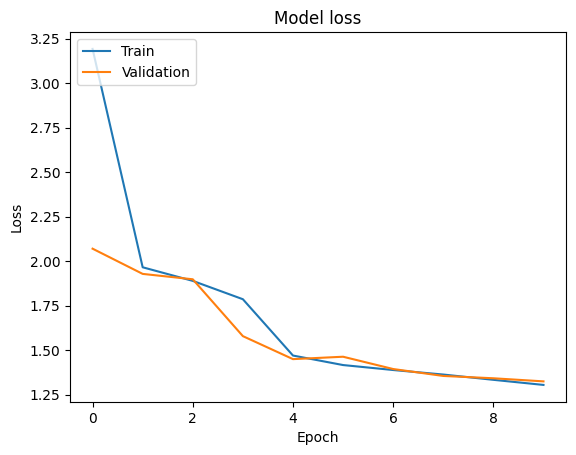

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss over each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

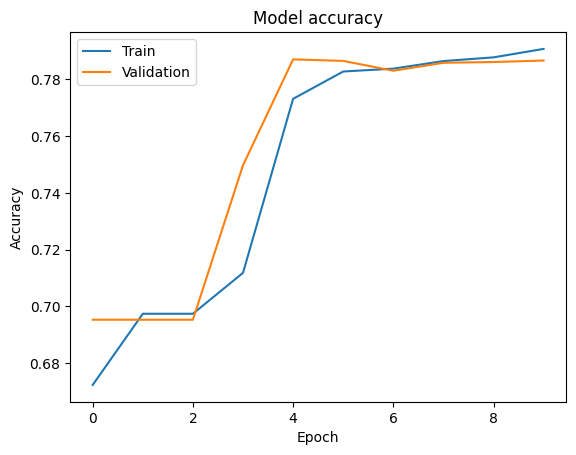

In [ ]:
# Plot the training and validation accuracy over each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Manual Testing on few of random comments**

---



In [ ]:
# print(X_train[0])

# xval = preprocess_text("Took online course. Day after Midterms I was the *only* one who turned in the next assignment. Rest of the year was 3 people turning in their homework. Took off points for incorrect COMMENTS, not just incorrect code. hyper-specific. bad teacher. wouldnt even help me install the software properly, gave no link to online instructions either.")
# print(xval)
# xval = word_tokenizer.texts_to_sequences([xval])
# print(xval)
# xval = pad_sequences(xval, padding='post', maxlen=maxlen)

# print(xval)
# output_probs = model.predict(xval)
# print(output_probs)

result = []

for i in range(0,10):
  xval = preprocess_text(sentences[i])
  xval = word_tokenizer.texts_to_sequences([xval])
  xval = pad_sequences(xval, padding='post', maxlen=maxlen)
  output_probs = model.predict(xval)
  result.append(str(star_rate[i]))
  result.append(str(difficulty[i]))
  result.append(str(output_probs[0][0]))
  result.append(str(output_probs[0][1]))

print("ActualQuality" +" " + "ActualDifficulty"+" "+ "PredictedQuality" +" " + "PredictedDifficulty")

for i in range(0,len(result),4):
  print("  "+ result[i] +"              " + result[i+1]+"              "+ result[i+2] +"              " + result[i+3])

1/1 [==============================] - 0s 64ms/step
ActualQuality ActualDifficulty PredictedQuality PredictedDifficulty
  4.0              2.0              3.982706              2.2653162
  4.0              1.0              2.2679965              3.6010911
  5.0              1.0              3.0837746              1.2269361
  4.5              5.0              3.4566624              2.2319765
  4.0              1.0              3.899865              1.9813935
  5.0              4.0              3.4378324              2.0721824
  2.5              5.0              1.3892561              3.845601
  5.0              1.0              3.6548214              2.4864717
  5.0              1.0              3.2335854              2.558734
  5.0              2.0              3.523105              2.1896558


## **Two Separate Models**

1.   We are using Classification Models for Predicting Quality and Difficulty
2.   We are going to convert the decimal difficulty levels to categorical variables



In [ ]:
import numpy as np

# Assume that the training data has been prepared with comments and their corresponding difficulty levels
# Difficulty levels should be represented as decimal values in the range of 1-5

# Define the maximum difficulty level (5) and the minimum difficulty level (1)
MAX_DIFFICULTY = 5.0
MIN_DIFFICULTY = 1.0

# Converting the decimal difficulty levels to categorical variables
def create_labels(difficulty_levels):
    num_labels = int(MAX_DIFFICULTY - MIN_DIFFICULTY + 1)
    labels = np.zeros((difficulty_levels.shape[0], num_labels))
    for i, difficulty in enumerate(difficulty_levels):
        label_index = int(difficulty - MIN_DIFFICULTY)
        labels[i, label_index] = 1
    return labels

star_rating = np.array(star_rate)
labelstar = create_labels(star_rating)
print(labelstar[0])

difficult = np.array(difficulty)
labeldiff = create_labels(difficult)
print(labelstar[0])
print(labeldiff[0])


[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0.]


## **Model for predicting Quality**

In [ ]:
y = labelstar

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
vocab_length = len(word_tokenizer.word_index) + 1

print(vocab_length)

maxlen = 50

59703


In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, RNN
from keras.layers import SimpleRNNCell
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional
from keras import regularizers
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.layers import RepeatVector, TimeDistributed
from keras.models import Model

optimizer = Adam(learning_rate=0.001)

lstm_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True)
lstm_model.add(embedding_layer)

lstm_model.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.2)) # Add dropout layer after the first LSTM layer

lstm_model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.2)) # Add dropout layer after the second LSTM layer

# Add a Dense layer to output the probability distribution over the possible difficulty levels
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
234/234 [==============================] - 74s 295ms/step - loss: 1.8127 - acc: 0.4272 - val_loss: 1.2794 - val_acc: 0.4699
Epoch 2/10
234/234 [==============================] - 69s 294ms/step - loss: 1.2014 - acc: 0.4955 - val_loss: 1.2252 - val_acc: 0.4845
Epoch 3/10
234/234 [==============================] - 68s 291ms/step - loss: 1.0767 - acc: 0.5478 - val_loss: 1.2063 - val_acc: 0.4795
Epoch 4/10
234/234 [==============================] - 78s 333ms/step - loss: 0.9753 - acc: 0.6055 - val_loss: 1.2420 - val_acc: 0.5019
Epoch 5/10
234/234 [==============================] - 77s 329ms/step - loss: 0.8847 - acc: 0.6596 - val_loss: 1.2471 - val_acc: 0.5124
Epoch 6/10
234/234 [==============================] - 79s 335ms/step - loss: 0.8073 - acc: 0.6980 - val_loss: 1.2850 - val_acc: 0.4897
Epoch 7/10
234/234 [==============================] - 76s 323ms/step - loss: 0.7428 - acc: 0.7339 - val_loss: 1.3648 - val_acc: 0.4829
Epoch 8/10
234/234 [==============================] - 7

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

292/292 [==============================] - 7s 26ms/step - loss: 1.6665 - acc: 0.4775


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.6664955615997314
Test Accuracy: 0.4775256812572479


In [ ]:
result = []

for i in range(0,10):
  xval = preprocess_text(sentences[i])
  xval = word_tokenizer.texts_to_sequences([xval])
  xval = pad_sequences(xval, padding='post', maxlen=maxlen)
  output_probs = lstm_model.predict(xval)
  output_probs = np.argmax(output_probs[0]) + MIN_DIFFICULTY
  result.append(str(star_rate[i]))
  result.append(str(output_probs))

print("ActualQuality" +" " + "PredictedQuality")

for i in range(0,len(result),2):
  print("  "+ result[i] +"              " + result[i+1])

1/1 [==============================] - 0s 28ms/step
ActualQuality PredictedQuality
  4.0              4.0
  4.0              2.0
  5.0              5.0
  4.5              4.0
  4.0              5.0
  5.0              5.0
  2.5              3.0
  5.0              5.0
  5.0              4.0
  5.0              5.0


## **Model for predicting Difficulty**

In [ ]:
y = labeldiff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
vocab_length = len(word_tokenizer.word_index) + 1

print(vocab_length)

maxlen = 50

59703


In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, RNN
from keras.layers import SimpleRNNCell
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional
from keras import regularizers
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.layers import RepeatVector, TimeDistributed
from keras.models import Model

optimizer = Adam(learning_rate=0.001)

lstm_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True)
lstm_model.add(embedding_layer)

lstm_model.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.2)) # Add dropout layer after the first LSTM layer

lstm_model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.2)) # Add dropout layer after the second LSTM layer

# Add a Dense layer to output the probability distribution over the possible difficulty levels
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
234/234 [==============================] - 85s 343ms/step - loss: 2.0022 - acc: 0.2851 - val_loss: 1.5481 - val_acc: 0.2669
Epoch 2/10
234/234 [==============================] - 74s 317ms/step - loss: 1.4745 - acc: 0.3508 - val_loss: 1.4694 - val_acc: 0.3487
Epoch 3/10
234/234 [==============================] - 80s 344ms/step - loss: 1.3433 - acc: 0.4342 - val_loss: 1.4615 - val_acc: 0.3617
Epoch 4/10
234/234 [==============================] - 74s 315ms/step - loss: 1.1767 - acc: 0.5315 - val_loss: 1.5158 - val_acc: 0.3915
Epoch 5/10
234/234 [==============================] - 75s 322ms/step - loss: 1.0074 - acc: 0.6202 - val_loss: 1.5963 - val_acc: 0.3953
Epoch 6/10
234/234 [==============================] - 74s 314ms/step - loss: 0.8546 - acc: 0.6909 - val_loss: 1.7272 - val_acc: 0.3874
Epoch 7/10
234/234 [==============================] - 70s 298ms/step - loss: 0.7531 - acc: 0.7317 - val_loss: 1.8238 - val_acc: 0.3923
Epoch 8/10
234/234 [==============================] - 7

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

292/292 [==============================] - 6s 19ms/step - loss: 2.2049 - acc: 0.3842


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 2.2049195766448975
Test Accuracy: 0.3842037618160248


In [ ]:
result = []

for i in range(0,10):
  xval = preprocess_text(sentences[i])
  xval = word_tokenizer.texts_to_sequences([xval])
  xval = pad_sequences(xval, padding='post', maxlen=maxlen)
  output_probs = lstm_model.predict(xval)
  output_probs = np.argmax(output_probs[0]) + MIN_DIFFICULTY
  result.append(str(difficulty[i]))
  result.append(str(output_probs))

print("ActualDifficulty" +" " + "PredictedDifficulty")

for i in range(0,len(result),2):
  print("  "+ result[i] +"              " + result[i+1])

1/1 [==============================] - 0s 40ms/step
ActualDifficulty PredictedDifficulty
  2.0              2.0
  1.0              1.0
  1.0              1.0
  5.0              5.0
  1.0              4.0
  4.0              1.0
  5.0              5.0
  1.0              3.0
  1.0              1.0
  2.0              2.0
